# K-nearest neighboors and Linear Distcriminant Analysis. 

L'algorithme des K-plus proches voisins et de Linear Discriminant analysis sont des méthodes assez simple par rapport au SVM, je les aies testées avec et sans PCA pour bien mettre en valeur l'utilité de cette méthode, j'ai également mis en valeur l'importance de l'équilibrage du dataset, que j'utiliserai dans les étapes suivantes. 

In [6]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import decomposition
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

from collections import Counter
import imblearn
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

warnings.filterwarnings("ignore")

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


### LOAD DATA

In [7]:
df = pd.read_csv('data/train.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X = features[:,3:18] # des features on été ajoutées depuis
N,M=X.shape
class_names = ["healthy","melanoma"]
print('il y a '+ str(M)+' features')

il y a 15 features


In [8]:
# Shuffle data randomly
indeces = np.arange(N)
np.random.shuffle(indeces)
X = X[indeces]
y = y[indeces]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

# K plus proches voisins. 

## K_plus proches voisins sans équilibrer le dataset, sans PCA

Best training Score: 0.5589285714285714
Normalized confusion matrix
[[0.90123457 0.09876543]
 [0.89830508 0.10169492]]


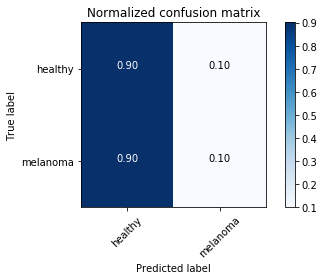

In [9]:
KNN = KNeighborsClassifier()
#cross validation
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=10)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))

y_pred = grid_KNN.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Le score est plutot bon, mais l'on remarque bien avec la matrice de confusion qu'équilibrer le dataset est nécessaire. Peut-être même que cela diminuera l'accuracy. Effectivement, le score après soumission au challenge Kaggle n'est pas bon du tout : -0.04178 je pense que cela est l'un des pires score obtenus. Nous allons voir si cela s'améliore en équilibrant le dataset. 

## K_plus proches voisins en équilibrant le dataset, sans PCA

In [10]:
#Equilibrer le dataset

from imblearn.over_sampling import SMOTE, ADASYN
X_train, y_train = ADASYN().fit_resample(X_train, y_train)

Best training Score: 0.6436251920122887
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.51851852 0.48148148]
 [0.40677966 0.59322034]]


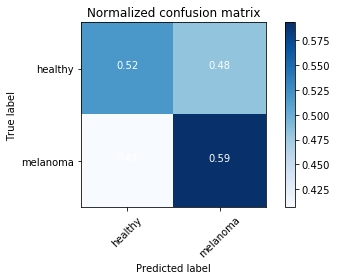

In [11]:
KNN = KNeighborsClassifier()
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=10)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Le score d'accuracy a augmenté, la matrice de confusion est un peu meilleure. J'ai tout de même essayé de soumettre le résultat sur Kaggle. Le score est toujours assez mauvais. Je pense que c'est lié au paramètre choisi par cross validation : 1 voisin cela a de fortes chances de donner de l'overfitting. Effectivement, en imposant une augmentation du nombre de voisins, l'accuracy diminue : ci dessous j'impose 5 voisins au minimum, mais la détection est vraiment mauvaise, il y a plus de faux positifs que de vrai positifs.
Peut-être qu'un PCA permettrait d'améliorer les choses. 

Best training Score: 0.4869431643625192
Best training params: {'n_neighbors': 7}
Normalized confusion matrix
[[0.4691358  0.5308642 ]
 [0.55932203 0.44067797]]


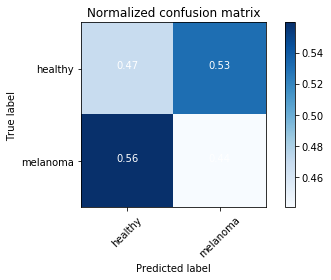

In [12]:
KNN = KNeighborsClassifier()
p_grid_KNN = {'n_neighbors': [5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=10)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## K_plus proches voisins en équilibrant le dataset, avec PCA

Afin de trouver le meilleur nombre de composants pour la PCA, je choisis le nombre de voisins qui maximise le score : 

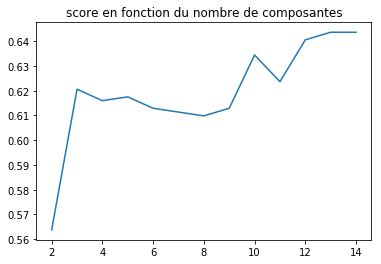

meilleur score pour 13 composantes
meilleur score : 0.6436251920122887


In [13]:
scores = []

for i in range(2,15) : 
    #Principal Component analysis
    pca = decomposition.PCA(n_components=i) 
    pca.fit(X_train)
    X_pca = pca.transform(X_train)
    
    KNN = KNeighborsClassifier()
    p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
    grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=10)
    grid_KNN.fit(X_pca, y_train)
    
    scores.append(grid_KNN.best_score_)

plt.plot(range(2,15),scores)
plt.title('score en fonction du nombre de composantes')
plt.show()
print('meilleur score pour '+str(np.argmax(scores)+2)+ ' composantes')
print('meilleur score : ' + str(max(scores)))

Best training Score: 0.6436251920122887
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.51851852 0.48148148]
 [0.40677966 0.59322034]]


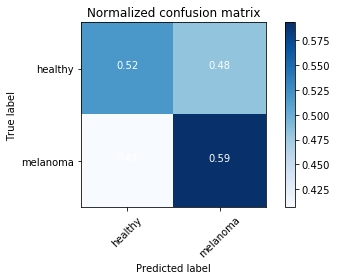

In [14]:
pca = decomposition.PCA(n_components=i) 
pca.fit(X_train)
X_pca = pca.transform(X_train)
Xtest_pca = pca.transform(X_test)

KNN = KNeighborsClassifier()
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=10)
grid_KNN.fit(X_pca, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(Xtest_pca)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

La matrice de confusion est meilleure, et le score est plutôt bon. Je souhaite tester KNN ou LDA avec leur meilleur score de PCA, cross validation, data set équilibré et les dernières features afin de comparer les deux méthodes. Je vais également implémenter le score de Matthews cette-fois ci. 

## Test avec plus de features : comparer LDA,QDA et KNN

In [15]:
df = pd.read_csv('data/train.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X = features[:,1:]
N,M=X.shape
class_names = ["healthy","melanoma"]
print('il y a '+ str(M)+' features')

il y a 29 features


In [16]:
# Shuffle data randomly
indeces = np.arange(N)
np.random.shuffle(indeces)
X = X[indeces]
y = y[indeces]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  


#Equilibrer le dataset

from imblearn.over_sampling import SMOTE, ADASYN
X_train, y_train = ADASYN().fit_resample(X_train, y_train)


#score de Matthews
scorer = make_scorer(matthews_corrcoef)

### KNN

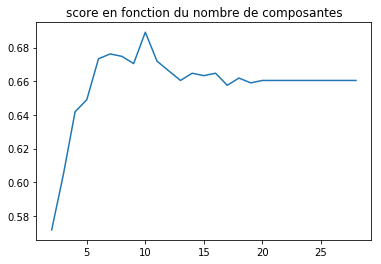

meilleur score pour 10 composantes
meilleur score : 0.6891117478510028


In [17]:
# Déterminer le meilleur paramètre pour le nombre de composantes : 

scores = []
for i in range(2,29) : 
    #Principal Component analysis
    pca = decomposition.PCA(n_components=i) 
    pca.fit(X_train)
    X_pca = pca.transform(X_train)

    KNN = KNeighborsClassifier()
    p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
    grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=10)
    grid_KNN.fit(X_pca, y_train)
    
    scores.append(grid_KNN.best_score_)

plt.plot(range(2,29),scores)
plt.title('score en fonction du nombre de composantes')
plt.show()
print('meilleur score pour '+str(np.argmax(scores)+2)+ ' composantes')
print('meilleur score : ' + str(max(scores)))

Best training Score: 0.6489971346704871
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.46835443 0.53164557]
 [0.59016393 0.40983607]]


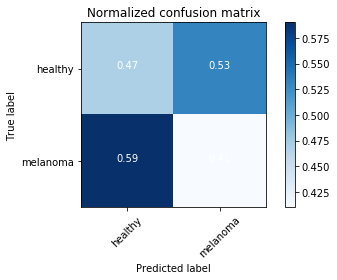

explained variance ratio for PCA : [0.46584287 0.14627685 0.1270165  0.05339723 0.04227366]


In [18]:
pca = decomposition.PCA(n_components=5) 
pca.fit(X_train)
X_pca = pca.transform(X_train)
Xtest_pca = pca.transform(X_test)

KNN = KNeighborsClassifier()
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=10)
grid_KNN.fit(X_pca, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(Xtest_pca)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print('explained variance ratio for PCA : ' + str((pca.explained_variance_ratio_)))

### LDA

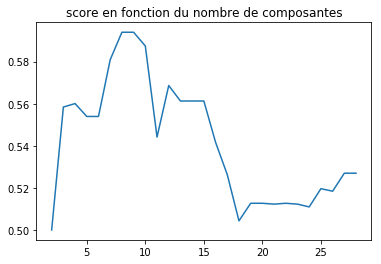

meilleur score pour 8 composantes
meilleur score : 0.5939542483660131


In [20]:
# Déterminer le meilleur paramètre pour le nombre de composantes : 

scores = []
for i in range(2,29) : 
    #Principal Component analysis
    pca = decomposition.PCA(n_components=i) 
    pca.fit(X_train)
    X_pca = pca.transform(X_train)

    lda = LinearDiscriminantAnalysis()
    lda_score = cross_val_score(lda,X=X_pca, y = y_train,cv=5,scoring = "balanced_accuracy")
    
    scores.append(max(lda_score))

plt.plot(range(2,29),scores)
plt.title('score en fonction du nombre de composantes')
plt.show()
print('meilleur score pour '+str(np.argmax(scores)+2)+ ' composantes')
print('meilleur score : ' + str(max(scores)))

Normalized confusion matrix
[[0.39240506 0.60759494]
 [0.37704918 0.62295082]]


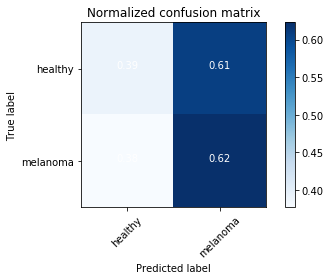

score0.553921568627451
explained variance ratio for PCA : [0.46584287 0.14627685 0.1270165  0.05339723 0.04227366 0.03290248]


In [21]:
pca = decomposition.PCA(n_components=6) 
pca.fit(X_train)
X_pca = pca.transform(X_train)
Xtest_pca = pca.transform(X_test)

lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=X_pca, y = y_train,cv=5,scoring = "balanced_accuracy")
lda.fit(X_pca,y_train)

y_pred = lda.predict(Xtest_pca)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print('score' + str(max(lda_score)))


print('explained variance ratio for PCA : ' + str((pca.explained_variance_ratio_)))

### QDA

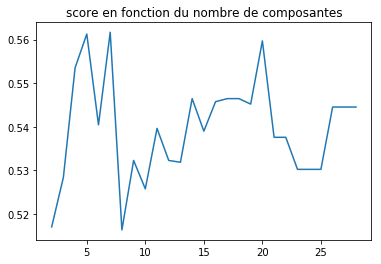

meilleur score pour 7 composantes
meilleur score : 0.5616830065359477


In [22]:
# Déterminer le meilleur paramètre pour le nombre de composantes : 

scores = []
for i in range(2,29) : 
    #Principal Component analysis
    pca = decomposition.PCA(n_components=i) 
    pca.fit(X_train)
    X_pca = pca.transform(X_train)

    lda = QuadraticDiscriminantAnalysis()
    lda_score = cross_val_score(lda,X=X_pca, y = y_train,cv=5,scoring = "balanced_accuracy")
    
    scores.append(max(lda_score))

plt.plot(range(2,29),scores)
plt.title('score en fonction du nombre de composantes')
plt.show()
print('meilleur score pour '+str(np.argmax(scores)+2)+ ' composantes')
print('meilleur score : ' + str(max(scores)))

Normalized confusion matrix
[[0.2278481  0.7721519 ]
 [0.18032787 0.81967213]]


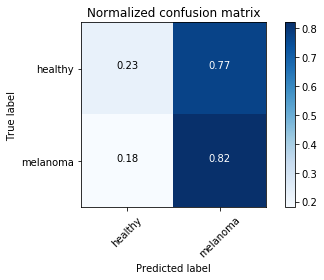

score : 0.5404411764705882
explained variance ratio for PCA : [0.46584287 0.14627685 0.1270165  0.05339723 0.04227366 0.03290248]


In [23]:
pca = decomposition.PCA(n_components=6) 
pca.fit(X_train)
X_pca = pca.transform(X_train)
Xtest_pca = pca.transform(X_test)

lda = QuadraticDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=X_pca, y = y_train,cv=5,scoring = "balanced_accuracy")
lda.fit(X_pca,y_train)

y_pred = lda.predict(Xtest_pca)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print('score : ' + str(max(lda_score)))
print('explained variance ratio for PCA : ' + str((pca.explained_variance_ratio_)))

# Conclusion : 
Avec le score de Matthews, et l'utilisation de toutes les features, cela semble être KNN qui est la meilleure méthode, avec un score presque 2 fois supérieur à celui obtenu par les autres méthodes. Cependant, lorsque j'ai soumis les prédiction à Kaggle, le score était toujours aussi mauvais. Je pense que c'est le problème d'overfitting qui persiste. J'ai changé pour la balanced_accuracy (meilleure pour les classifications binaires d'après la documentation de sci-kit learn) dans l'exemple ci-dessous, les méthodes semblent avoir de bon résultats et c'est encore les K nearest Neighboors qui montrent les meilleurs résultats, mais toujours avec un seul voisin sélectionné, cela ne me semble pas fiable. 

Pour moi, avec la balanced Accuracy c'est la linear analysis qui semble la meilleure car on dirait que la Quadratic Analysis détecte beaucoup trop de mélanomes. Comme la linear Discriminant Analysis me semblait meilleure, je l'ai soumis et le score était assez mauvais.
Quand à la Quadratic Discriminant analysis, elle a montré plusieurs fois des matrices de confusion avec une mauvaise prédiction mais un bon score de pertinence. 

D'après les scores de PCA, ce sont les trois premières variables qui sont les plus utiles à la classification, cependant, si je garde seulement les trois premières composantes du PCA, la classification est mauvaise et donne beaucoup de mélanomes. Les plus petites composantes sont donc assez utiles. 

Au vues de résultats, je vais essayer d'autres méthodes, comme SVM ou les méthodes d'ensemble pour obtenir une meilleure classification. 

# Appendice : code utilisé pour générer les CSV Kaggle

## Essai 4  :

In [24]:
#loading data
#train set :
df = pd.read_csv('data/train.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y_train = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X_train = features[:,1:18] #Toutes les features n'étaient pas encore calculées

#test set : 
df = pd.read_csv('data/test.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X_test = features[:,1:18]

In [25]:
# Looking for the best hyperparameters
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=10)
grid_KNN.fit(X_train, y_train)

y = grid_KNN.predict(X_test)

In [26]:
df_submission = pd.read_csv('data/test.csv')

In [27]:
i = 0
for Id in df_submission['ImageId']:
    if Id != names[i] : 
        print('mismatch')
    value = y[i] # Draw a random number between 0 and 1 : binary classification : put here the result of
    i = i+1                # your classifier
    df_submission.loc[df_submission['ImageId'] == Id, 'Malignant'] = value
df_submission['Malignant'] = df_submission['Malignant'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('data/ESSAI4.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file

     ImageId  Malignant
0  IM_000788          0
1  IM_000640          0
2  IM_000889          1


## ESSAI 5

In [28]:
ros = RandomOverSampler(random_state=3)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Looking for the best hyperparameters
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=10)
grid_KNN.fit(X_train, y_train)

y = grid_KNN.predict(X_test)

In [29]:
df_submission = pd.read_csv('data/test.csv')

i = 0
for Id in df_submission['ImageId']:
    if Id != names[i] : 
        print('mismatch')
    value = y[i] # Draw a random number between 0 and 1 : binary classification : put here the result of
    i = i+1                # your classifier
    df_submission.loc[df_submission['ImageId'] == Id, 'Malignant'] = value
df_submission['Malignant'] = df_submission['Malignant'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('data/ESSAI5.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file

     ImageId  Malignant
0  IM_000788          1
1  IM_000640          1
2  IM_000889          1


# ESSAI 14

In [30]:
#loading data
#train set :
df = pd.read_csv('data/train.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y_train = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X_train = features[:,1:] #Toutes les features n'étaient pas encore calculées

#test set : 
df = pd.read_csv('data/test.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X_test = features[:,1:]

In [31]:
from sklearn.preprocessing import StandardScaler

# Shuffle data randomly
N,M=X_train.shape
indeces = np.arange(N)
np.random.shuffle(indeces)
X_train = X_train[indeces]
y_train = y_train[indeces]

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  


#Equilibrer le dataset

from imblearn.over_sampling import SMOTE, ADASYN
X_train, y_train = ADASYN().fit_resample(X_train, y_train)

In [32]:
pca = decomposition.PCA(n_components=13) 
pca.fit(X_train)
X_pca = pca.transform(X_train)
Xtest_pca = pca.transform(X_test)

p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring=scorer, cv=10)
grid_KNN.fit(X_pca, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(Xtest_pca)


Best training Score: 0.2720385874581243
Best training params: {'n_neighbors': 1}


In [33]:
df_submission = pd.read_csv('data/test.csv')

i = 0
for Id in df_submission['ImageId']:
    if Id != names[i] : 
        print('mismatch')
    value = y_pred[i] # Draw a random number between 0 and 1 : binary classification : put here the result of
    i = i+1                # your classifier
    df_submission.loc[df_submission['ImageId'] == Id, 'Malignant'] = value
df_submission['Malignant'] = df_submission['Malignant'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('data/ESSAI14.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file

     ImageId  Malignant
0  IM_000788          1
1  IM_000640          1
2  IM_000889          0


# ESSAI 16 : LDA

In [34]:
#loading data
#train set :
df = pd.read_csv('data/train.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y_train = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X_train = features[:,1:] #Toutes les features n'étaient pas encore calculées

#test set : 
df = pd.read_csv('data/test.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X_test = features[:,1:]

In [35]:
from sklearn.preprocessing import StandardScaler

# Shuffle data randomly
N,M=X_train.shape
indeces = np.arange(N)
np.random.shuffle(indeces)
X_train = X_train[indeces]
y_train = y_train[indeces]

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  


#Equilibrer le dataset

from imblearn.over_sampling import SMOTE, ADASYN
X_train, y_train = ADASYN().fit_resample(X_train, y_train)

In [36]:
pca = decomposition.PCA(n_components=18) 
pca.fit(X_train)
X_pca = pca.transform(X_train)
Xtest_pca = pca.transform(X_test)

lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=X_pca, y = y_train,cv=5,scoring = "balanced_accuracy")
lda.fit(X_pca,y_train)

y_pred = lda.predict(Xtest_pca)

print(max(lda_score))

0.5144787644787645


In [37]:
df_submission = pd.read_csv('data/test.csv')

i = 0
for Id in df_submission['ImageId']:
    if Id != names[i] : 
        print('mismatch')
    value = y_pred[i] # Draw a random number between 0 and 1 : binary classification : put here the result of
    i = i+1                # your classifier
    df_submission.loc[df_submission['ImageId'] == Id, 'Malignant'] = value
df_submission['Malignant'] = df_submission['Malignant'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('data/ESSAI16.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file

     ImageId  Malignant
0  IM_000788          0
1  IM_000640          0
2  IM_000889          1
